In [0]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils import data
import torchvision
import torchvision.transforms as transforms
import os
import argparse
import matplotlib.pyplot as plt
from torch.autograd import Variable
from keras.utils.np_utils import to_categorical

In [0]:
(X_train, y_train),(X_test,y_test)= tf.keras.datasets.cifar10.load_data()

In [0]:
X_train,remove_trainx, y_train, remove_trainy=train_test_split(X_train,y_train,test_size=0.8,stratify=y_train,random_state=875)
mean= [0,0,0]
std = [1,1,1]
normalizer = transforms.Normalize(mean=mean, std=std) 


In [0]:
def createmodel():
  model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
  model.fc = torch.nn.Linear(512,10)
  model = torch.nn.DataParallel(model)
  return model

In [0]:
y_train=y_train.reshape((10000,))
tensor_x = torch.Tensor(X_train)# transform to torch tensor
tensor_x = tensor_x.permute(0,3,1,2)
tensor_y = torch.Tensor(y_train)

my_dataset = data.TensorDataset(tensor_x,tensor_y) # create your datset
trainloader = data.DataLoader(my_dataset,batch_size=100, shuffle=True, num_workers=2) # create your dataloader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cudnn.benchmark = True


In [0]:
y_test=y_test.reshape((10000,))
tensor_xtest = torch.Tensor(X_test)# transform to torch tensor
tensor_xtest = tensor_xtest.permute(0,3,1,2)
tensor_ytest = torch.Tensor(y_test)
my_datasettest = data.TensorDataset(tensor_xtest,tensor_ytest) # create your datset
testloader = data.DataLoader(my_datasettest,batch_size=100, shuffle=True, num_workers=2)


In [0]:
def plt_graph(plt_accur,plt_loss, plttest_accur):
  ax = plt.subplot(111)
  ax.plot(plt_accur,'g',label="Training Accuracy")
  ax.plot(plttest_accur, 'b',label="Test Accuracy")
  ax.legend()
  plt.show()
  plt.figure()
  plt.plot(plt_loss,'r',label="Training Loss")
  plt.show()
  print("Final Train Accuracy: ",plt_accur[-1])
  print("Final Test Accuracy: ",plttest_accur[-1])

#1. Training on Resnet without Augmentation

In [8]:
plt_loss=[]
plt_accur=[]
model=createmodel()
model.cuda
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.01)
def train(epoch):
  model.train()
  train_loss = 0
  correct = 0
  total = 0
  for batch_idx, (inputs, targets) in enumerate(trainloader):
    inputs, targets = inputs.cuda(), targets.cuda()
    targets=targets.long()
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  inputs=tensor_x.cuda()
  targets=tensor_y.cuda()
  outputs=model(inputs)
  _, predicted = outputs.max(1)
  total += targets.size(0)
  correct += predicted.eq(targets).sum().item()
  plt_loss.append(train_loss/(batch_idx+1))
  plt_accur.append(100.*correct/total)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [0]:
plttest_loss=[]
plttest_accur=[]

def test(epoch):
  model.eval()
  test_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
     for batch_idx, (inputs, targets) in enumerate(testloader):
      inputs = inputs.to(device)
      targets = targets.to(device)
      targets=targets.long()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss += loss.item()
      _, predicted = outputs.max(1)
      total += targets.size(0)
      correct += predicted.eq(targets).sum().item()
  plttest_accur.append(100.*correct/total)

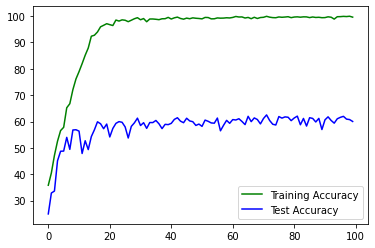

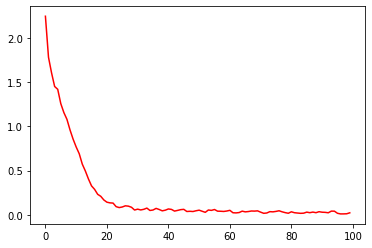

Final Train Accuracy:  99.57
Final Test Accuracy:  60.02


In [10]:
for epoch in range(100):
  train(epoch)
  test(epoch)

plt_graph(plt_accur,plt_loss, plttest_accur)

#2. Mixup augmentation

In [0]:
def mixup_data(x, y,mix, use_cuda=True):
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = mix * x + (1 - mix) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, mix

def mixup_criterion(criterion, pred, y_a, y_b, mix):
    return mix * criterion(pred, y_a) + (1 - mix) * criterion(pred, y_b)


In [28]:
plt_loss=[]
plt_accur=[]
model=createmodel()
model.cuda
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.01)
def trainmix(epoch,mix):
    model.train()
    train_loss = 0
    reg_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.cuda(), targets.cuda()
        targets=targets.long()
        
        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets,mix,True)
        inputs, targets_a, targets_b = map(Variable, (inputs,targets_a, targets_b))
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()

    inputs=tensor_x.cuda()
    targets=tensor_y.cuda()
    outputs=model(inputs)
    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += predicted.eq(targets).sum().item()
    plt_loss.append(train_loss/(batch_idx+1))
    plt_accur.append(100.*correct/total)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [0]:
plttest_loss=[]
plttest_accur=[]

def testmix(epoch):
  model.eval()
  test_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
      inputs = tensor_xtest.to(device)
      targets = tensor_ytest.to(device)
      targets=targets.long()
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      test_loss += loss.item()
      _, predicted = outputs.max(1)
      total += targets.size(0)
      correct += predicted.eq(targets).sum().item()
  #plttest_loss.append(test_loss/(batch_idx+1))
      plttest_accur.append(100.*correct/total)    #return (train_loss/batch_idx, reg_loss/batch_idx, 100.*correct/total)



Mixup with alpha 0.2

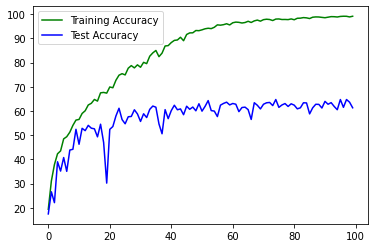

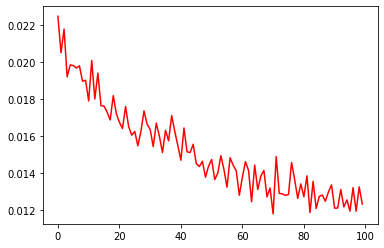

Final Train Accuracy:  99.13
Final Test Accuracy:  61.33


In [14]:
mix_1 = np.random.beta(a=0.2, b=0.2, size=None)


for epoch in range(100):
   trainmix(epoch,mix_1)
   testmix(epoch)

plt_graph(plt_accur,plt_loss, plttest_accur)

Mix up with alpha 0.4

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


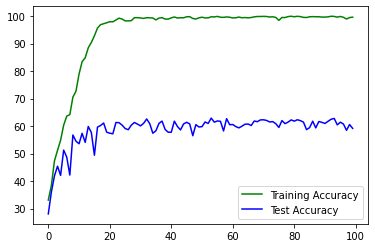

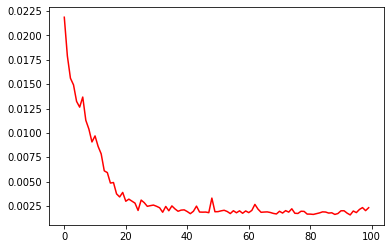

Final Train Accuracy:  99.6
Final Test Accuracy:  59.15


In [30]:
model=createmodel()
model.cuda
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.01)
plt_loss=[]
plt_accur=[]
plttest_loss=[]
plttest_accur=[]
mix_2 = np.random.beta(a=0.4, b=0.4, size=None)
for epoch in range(100):
   trainmix(epoch,mix_2)
   testmix(epoch)

plt_graph(plt_accur,plt_loss, plttest_accur)

#3. Cut out Augmentation

In [0]:
def cut_out(X_train_cut):
    num = np.random.uniform(0,1,X_train_cut.shape[0])
    for i in range(X_train_cut.shape[0]):
        if num[i]>=0.5:
            idx = np.random.randint(0,31,size=(2))
            row1 = idx[0]-7
            row2 = idx[0]+8
            clm1 = idx[1]-7
            clm2 = idx[1]+8
            if row1<0:
                row1 = 0
            if row2>31:
                row2 = 31
            if clm1<0:
                clm = 0
            if clm2>31:
                clm =31
            X_train_cut[i,:,row1:row2,clm1:clm2] = 0
    return X_train_cut


In [17]:
plt_loss=[]
plt_accur=[]
model=createmodel()
model.cuda
def traincut(epoch):
  model.train()
  train_loss = 0
  correct = 0
  total = 0
  for batch_idx, (inputs, targets) in enumerate(trainloader):
    inputs=cut_out(inputs)
    
    targets=targets.long()
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
  inputs=tensor_x.cuda()
  targets=tensor_y.cuda()
  outputs=model(inputs)
  train_loss += loss.item()
  _, predicted = outputs.max(1)
  total += targets.size(0)
  correct += predicted.eq(targets).sum().item()
  plt_loss.append(train_loss/(batch_idx+1))
  plt_accur.append(100.*correct/total)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [0]:
plttest_loss=[]
plttest_accur=[]

def testcut(epoch):
  model.eval()
  test_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
      inputs = tensor_xtest.to(device)
      targets = tensor_ytest.to(device)
      targets=targets.long()
      outputs = model(inputs)
      loss = criterion(outputs, targets)

  test_loss += loss.item()
  _, predicted = outputs.max(1)
  total += targets.size(0)
  correct += predicted.eq(targets).sum().item()
  plttest_accur.append(100.*correct/total)

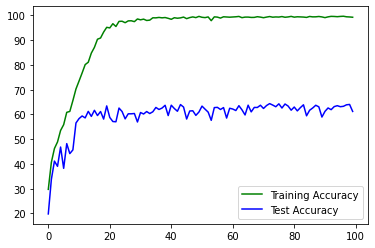

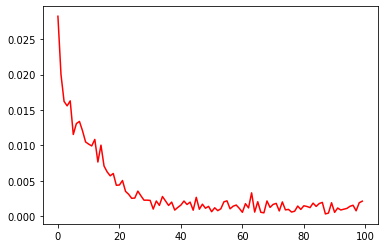

Final Train Accuracy:  99.29
Final Test Accuracy:  61.22


In [19]:
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.01)
for epoch in range(100):
  traincut(epoch)
  testcut(epoch)

plt_graph(plt_accur,plt_loss, plttest_accur)

#4. Standard Augmentation

In [0]:
def standard_aug_new(batch_train_data, K):
    batch_train_data=batch_train_data.detach().cpu().numpy()
    num = np.random.uniform(0,1,batch_train_data.shape[0])
    idx = np.random.randint(-K,K,size=(batch_train_data.shape[0],2))
    for i in range(batch_train_data.shape[0]):
        batch_train_data[i] = np.roll(batch_train_data[i],idx[i,0], axis = 1)
        batch_train_data[i] = np.roll(batch_train_data[i],idx[i,1], axis = 2)
        if idx[i,0]<0:
            batch_train_data[i,:,31-idx[i,0]:31,:] = 0
        else:
            batch_train_data[i,:,0:idx[i,0],:] = 0
        if idx[i,1]<0:
            batch_train_data[i,:,:,31-idx[i,0]:31] = 0
        else:
            batch_train_data[i,:,:,0:idx[i,0]] = 0
        if num[i]>0.5:
            batch_train_data[i] = np.flip(batch_train_data[i],axis=2)
    return batch_train_data

In [21]:
plt_loss=[]
plt_accur=[]
model=createmodel()
model.cuda
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.01)
def trainstdaug(epoch):
  model.train()
  train_loss = 0
  correct = 0
  total = 0
  for batch_idx, (inputs, targets) in enumerate(trainloader):
    inputs=torch.Tensor(standard_aug_new(inputs,4))
    inputs, targets = inputs.to(device), targets.to(device)
    targets=targets.long()
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
  train_loss += loss.item()
  inputs=tensor_x.cuda()
  targets=tensor_y.cuda()
  outputs=model(inputs)
  _, predicted = outputs.max(1)
  total += targets.size(0)
  correct += predicted.eq(targets).sum().item()
  plt_loss.append(train_loss/(batch_idx+1))
  plt_accur.append(100.*correct/total)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [0]:
plttest_loss=[]
plttest_accur=[]

def teststdaug(epoch):
  model.eval()
  test_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
      inputs = tensor_xtest.to(device)
      targets = tensor_ytest.to(device)
      targets=targets.long()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss += loss.item()
      _, predicted = outputs.max(1)
      total += targets.size(0)
      correct += predicted.eq(targets).sum().item()
  plttest_accur.append(100.*correct/total)

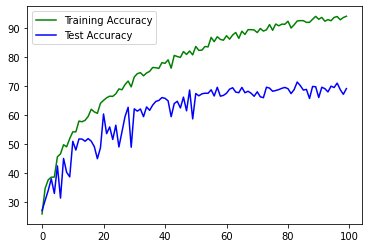

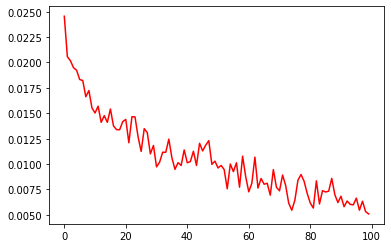

Final Train Accuracy:  94.07
Final Test Accuracy:  69.18


In [23]:
for epoch in range(100):
  trainstdaug(epoch)
  teststdaug(epoch)

plt_graph(plt_accur,plt_loss, plttest_accur)

#5. Combination of all augmentations

In [43]:
plt_loss=[]
plt_accur=[]
plttest_loss=[]
plttest_accur=[]
model=createmodel()
model.cuda
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.01)
mix_1 = np.random.beta(a=0.2, b=0.2, size=None)

def train_combine(epoch,mix):
    model.train()
    train_loss = 0
    reg_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.cuda(), targets.cuda()
        inputs = torch.Tensor(standard_aug_new(inputs,4))
        inputs = cut_out(inputs)
        targets=targets.long()
        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets,mix,True)
        inputs, targets_a, targets_b = inputs.to(device), targets_a.to(device), targets_b.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()
    train_loss += loss.item()
    inputs=tensor_x.cuda()
    targets=tensor_y.cuda()
    outputs=model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += predicted.eq(targets).sum().item()
    plt_loss.append(train_loss/(batch_idx+1))
    plt_accur.append(100.*correct/total)

def test_combine(epoch):
  model.eval()
  test_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
      inputs = tensor_xtest.to(device)
      targets = tensor_ytest.to(device)
      targets=targets.long()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss += loss.item()
      _, predicted = outputs.max(1)
      total += targets.size(0)
      correct += predicted.eq(targets).sum().item()
  plttest_accur.append(100.*correct/total)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


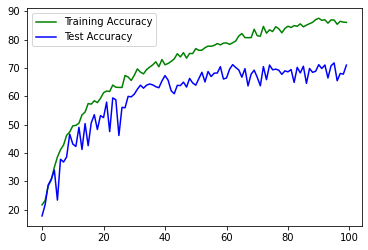

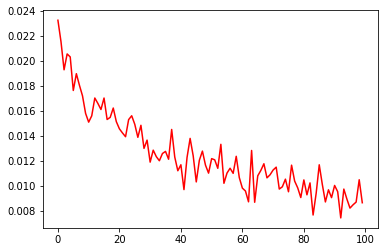

Final Train Accuracy:  86.04
Final Test Accuracy:  70.98


In [44]:
for epoch in range(100):
  train_combine(epoch,mix_2)
  test_combine(epoch)

plt_graph(plt_accur,plt_loss, plttest_accur)

#6. Role of data augmentation
Data augmentation helps to extract the features from the data which were not possible with simple passes. As we have used three techniques for data augmentation , the train and test accuracy has increased in all cases as compared to simple training and testing.

Standard augmentation shows the maximum accuracy on the test data 69.18 and mix up at 61.03 and cutout at 61.23 , we can see gradual increase in accuracy. So for combination of of all data augmentation accuracy hits the highest at 70.98. The train accuracy of combined data augmentation is 86.04 so with more epochs it will improve. Test accuracy is higher now and the loss convergence is slower as we are running only 100 epochs.

